In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from os import listdir
from numpy import asarray
from numpy import vstack
import random
import PIL
from os.path import isfile, join
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import save_image


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
class EncodeModule(nn.Module):
    def __init__(self, in_c, out_c, batchnorm=True):
        super(EncodeModule, self).__init__()
        self.layers = nn.Sequential()
        self.layers.add_module('conv', nn.Conv2d(in_c, out_c, 4, stride=2, padding=1))
        if batchnorm:
            self.layers.add_module('bn', nn.BatchNorm2d(out_c))
        self.layers.add_module('relu', nn.LeakyReLU(negative_slope=0.2, inplace=True))

    def forward(self, x):
        out = self.layers(x)
        #print(out.size())
        return out


class DecodeModule(nn.Module):
    def __init__(self, in_c, out_c, batchnorm=True, dropout=False):
        super(DecodeModule, self).__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, 4, stride=2)
        self.layers = nn.Sequential()
        if batchnorm:
            self.layers.add_module('bn', nn.BatchNorm2d(out_c*2))
        if dropout:
            self.layers.add_module('do', nn.Dropout2d(p=0.5, inplace=True))
        self.layers.add_module('relu', nn.ReLU(inplace=True))

    def forward(self, x1, x2):
        x1 = self.up(x1)
        dw = x2.size(2) - x1.size(2)
        dh = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [dw // 2, dw - dw // 2, dh // 2, dh - dh // 2])
        #print("x1", x1.size())
        #print("x2", x2.size())
        x = torch.cat([x1, x2], dim=1)
        out = self.layers(x)
        #print(out.size())
        return out


class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        # C64-C128-C256-C512-C512-C512-C512-C512
        self.e1 = EncodeModule(3, 64, batchnorm=False)  # 256 -> 128
        self.e2 = EncodeModule(64, 128)  # 128 -> 64
        self.e3 = EncodeModule(128, 256)  # 64 -> 32
        self.e4 = EncodeModule(256, 512)  # 32 -> 16
        self.e5 = EncodeModule(512, 512)  # 16 -> 8
        self.e6 = EncodeModule(512, 512)  # 8 -> 4
        self.e7 = EncodeModule(512, 512)  # 4 -> 2
        self.e8 = EncodeModule(512, 512, batchnorm=False)  # 2 -> 1

        # CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
        self.d1 = DecodeModule(512, 512, dropout=True)
        self.d2 = DecodeModule(1024, 512, dropout=True)
        self.d3 = DecodeModule(1024, 512, dropout=True)
        self.d4 = DecodeModule(1024, 512)
        self.d5 = DecodeModule(1024, 256)
        self.d6 = DecodeModule(512, 128)
        self.d7 = DecodeModule(256, 64)
        self.out = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.e1(x)
        x2 = self.e2(x1)
        x3 = self.e3(x2)
        x4 = self.e4(x3)
        x5 = self.e5(x4)
        x6 = self.e6(x5)
        x7 = self.e7(x6)
        x8 = self.e8(x7)

        y = self.d1(x8, x7)
        y = self.d2(y, x6)
        y = self.d3(y, x5)
        y = self.d4(y, x4)
        y = self.d5(y, x3)
        y = self.d6(y, x2)
        y = self.d7(y, x1)
        return self.out(y)

In [ ]:
def convert_to_tan(img):
  img = (img - 0.5) / 0.5
  return img 

In [ ]:
def inverse_convert_to_tan(img):
  img = (img * 0.5) + 0.5
  return img 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


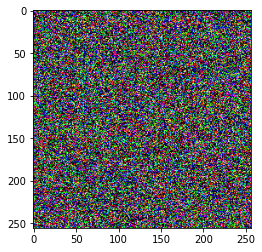

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 0.0293,  0.2167,  0.0137,  ..., -0.1235,  0.4289,  0.4038],
         [ 0.5855, -0.3600, -0.9071,  ..., -0.4224, -0.8846, -0.2685],
         [ 0.3026,  0.7198, -0.0231,  ...,  0.1631,  0.2835, -0.1653],
         ...,
         [-0.0828, -0.8482, -0.1617,  ...,  0.7670, -0.9991,  0.2542],
         [ 0.0973, -0.3747, -0.7973,  ..., -0.9340, -0.8149, -0.1340],
         [ 0.3651, -0.5379,  0.0654,  ..., -0.7370, -0.5208, -0.2970]],

        [[ 0.0759,  0.1644, -0.2839,  ..., -0.6297, -0.7111, -0.0820],
         [ 0.5952,  0.2124,  0.8677,  ..., -0.3703, -0.3257,  0.4697],
         [ 0.6800,  0.9875,  0.8646,  ...,  0.6793,  0.9493,  0.7607],
         ...,
         [-0.4781,  0.6708,  0.0648,  ..., -0.4672, -0.1449,  0.0415],
         [ 0.0812,  0.4589,  0.9569,  ..., -0.3631,  0.1800, -0.1583],
         [ 0.1960,  0.0303, -0.2453,  ...,  0.6167, -0.8724, -0.4973]],

        [[ 0.1003, -0.3828, -0.5231,  ..., -0.0487, -0.5935, -0.1335],
         [-0.5381, -0.6338, -0.9633,  ...,  0

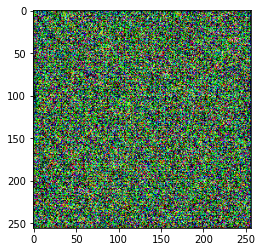

In [ ]:
unet = GeneratorNet()
x    = torch.randn(2, 3, 256, 256)
result = unet(x)
print(result.shape)
print(x[0].size())
plt.imshow(x[0].permute(2, 1, 0))
print(x[0].size())
plt.show()
print(result[0].detach())
print(inverse_convert_to_tan(result[0].detach()))
plt.imshow((result[0].detach()).permute(2,1,0))
plt.show()

In [ ]:
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()

        n_in = 6        # number of input channels
        n_out = 64      # number of output channels (i.e., number of filter in the last conv layer)

        self.kernel_size = 4
        self.padding = 1

        self.model = nn.Sequential(
            nn.Conv2d(n_in, n_out, kernel_size=self.kernel_size, stride=2, padding=self.padding),
            nn.LeakyReLU(0.2, True),
            self._get_layer(n_out, 2*n_out, 2),
            self._get_layer(2*n_out, 4*n_out, 2),
            self._get_layer(4*n_out, 8*n_out, 1),
            nn.Conv2d(8 * n_out, 1, kernel_size=self.kernel_size, stride=1, padding=self.padding),
        )

    def forward(self, input):
        return self.model(input)

    def _get_layer(self, n_input_channels, n_output_channels, stride):
        return nn.Sequential(
            nn.Conv2d(n_input_channels, n_output_channels, kernel_size=self.kernel_size, stride=stride, padding=self.padding),
            nn.BatchNorm2d(n_output_channels),
            nn.LeakyReLU(0.2, True)
        )

In [ ]:
sampleIn0 = torch.randn([1, 3, 256, 256])
sampleIn1 = torch.randn([1, 3, 256, 256])
sample = torch.cat([sampleIn0, sampleIn1], dim = 1)
dis = DiscriminatorNet()
out = dis(sample)
print(out.shape)

torch.Size([1, 1, 30, 30])


In [ ]:
class Pix2PixModel(nn.Module):
    def __init__(self, lr, betas, weight_decay, disc_mult, l1_mult, l1_only, gan_only=False):
        super(Pix2PixModel, self).__init__()
        self.discriminator = DiscriminatorNet()
        self.generator = GeneratorNet()

        self.opt_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=lr, weight_decay=weight_decay,
                                                  betas=betas)
        self.opt_generator = torch.optim.Adam(self.generator.parameters(), lr=lr, weight_decay=weight_decay,
                                              betas=betas)

        self.discriminator.apply(self.init_weights)
        self.generator.apply(self.init_weights)

        self.disc_mult = disc_mult
        self.l1_mult = l1_mult
        self.l1_only = l1_only
        self.gan_only = gan_only
        self.loss = nn.MSELoss()
        self.l1loss = nn.L1Loss()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def init_weights(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    def forward(self, real_x, real_y):
        self.real_x = real_x
        self.real_y = real_y
        self.generated = self.generator.forward(self.real_x)
        return self.generated

    def backward(self):
        if self.l1_only:
            loss_generator = self.l1_mult * self.l1loss.forward(self.generated, self.real_y)
            self.opt_generator.zero_grad()
            loss_generator.backward()
            self.opt_generator.step()
            return loss_generator.data, None

        pred_fake = self.discriminator(torch.cat((self.real_x, self.generated), 1))

        loss_generator = self.loss(pred_fake, torch.ones_like(pred_fake, device=self.device,
                                                              requires_grad=False)) + self.l1_mult * self.l1loss.forward(
            self.generated, self.real_y)

        self.opt_generator.zero_grad()
        loss_generator.backward()
        self.opt_generator.step()

        if self.gan_only:
            d_input_fake = self.generated.detach()
            d_input_real = self.real_y
        else:
            d_input_fake = torch.cat((self.real_x, self.generated), 1).detach()
            d_input_real = torch.cat((self.real_x, self.real_y), 1)
        pred_fake = self.discriminator(d_input_fake)
        pred_real = self.discriminator(d_input_real)
        loss_discriminator = self.disc_mult * (
                self.loss(pred_fake, torch.zeros_like(pred_fake, device=self.device, requires_grad=False))
                + self.loss(pred_real, torch.ones_like(pred_real, device=self.device, requires_grad=False))
        )

        self.opt_discriminator.zero_grad()
        loss_discriminator.backward()
        self.opt_discriminator.step()

        return loss_generator.data, loss_discriminator.data

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device {device}")

Using device cuda:0


In [ ]:
def to_img(x):
    #x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), x.size(1), x.size(2), x.size(3))
    return x

In [ ]:
def to_img_changed(img):
    img = (img * 0.5) + 0.5
    img = img.view(img.size(0), img.size(1), img.size(2), img.size(3))
    return img 

In [ ]:
class DoubleCompose(transforms.Compose):
    def __init__(self, *args, **kwargs):
        super(DoubleCompose, self).__init__(*args, **kwargs)

    def __call__(self, image, target):
        seed = np.random.randint(2147483647)
        random.seed(seed)
        t_image = super(DoubleCompose, self).__call__(image)
        random.seed(seed)
        t_target = super(DoubleCompose, self).__call__(target)
        return t_image, t_target


In [ ]:
def load_images(path, batch_size=32):
  print("creating dataloaders...")

  transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

  train_map_set = torchvision.datasets.ImageFolder(path + "train_map", transform=transform)
  val_map_set = torchvision.datasets.ImageFolder(path + "val_map", transform=transform)
  test_map_set = torchvision.datasets.ImageFolder(path + "test_map", transform=transform)

  train_sat_set = torchvision.datasets.ImageFolder(path + "train_sat", transform=transform)
  val_sat_set = torchvision.datasets.ImageFolder(path + "val_sat", transform=transform)
  test_sat_set = torchvision.datasets.ImageFolder(path + "test_sat", transform=transform)

  num_workers = 0

  train_map_loader = torch.utils.data.DataLoader(train_map_set, batch_size=batch_size, num_workers=num_workers)
  val_map_loader = torch.utils.data.DataLoader(val_map_set, batch_size=batch_size, num_workers=num_workers)
  test_map_loader = torch.utils.data.DataLoader(test_map_set, batch_size=batch_size, num_workers=num_workers)

  train_sat_loader = torch.utils.data.DataLoader(train_sat_set, batch_size=batch_size, num_workers=num_workers)
  val_sat_loader = torch.utils.data.DataLoader(val_sat_set, batch_size=batch_size, num_workers=num_workers)
  test_sat_loader = torch.utils.data.DataLoader(test_sat_set, batch_size=batch_size, num_workers=num_workers)

  print("done")

  return train_map_loader, val_map_loader, test_map_loader, train_sat_loader, val_sat_loader, test_sat_loader

train_map_loader, val_map_loader, test_map_loader, train_sat_loader, val_sat_loader, test_sat_loader = load_images('/content/drive/MyDrive/aps360/trainvaltest/', batch_size=1)


creating dataloaders...


FileNotFoundError: ignored

In [ ]:
model = Pix2PixModel(lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-8, disc_mult=0.5, l1_mult=100, l1_only=False)
model.to(device)

SigurdModel(
  (discriminator): ArtNet(
    (model): Sequential(
      (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (4): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (5): Conv2

In [ ]:
start_epoch = 0
num_epochs = 200
batch_size = 1

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

In [ ]:
loss_G_array = []
loss_D_array = []

for epoch in range(start_epoch, num_epochs):
    for (n, (sat_images, _)), (n1, (map_images, _)) in zip(enumerate(train_sat_loader), enumerate(train_map_loader)):
        #sat_images = convert_to_tan(sat_images)
        #map_images = convert_to_tan(map_images)
        sat_images = sat_images.to(device)
        map_images = map_images.to(device)
        #img = img.view(img.size(0), -1)
        
        img_pred = model.forward(sat_images, map_images)
        loss_G, loss_D = model.backward()
        print("-----" + str(n) + "-----")
        print("Loss G: " + str(loss_G.item()))
        print("Loss G: " + str(loss_D.item()))

    # ===================user interaction========================
    print('epoch [{}/{}], loss G:{:.4f}, loss D: {:.4f}'.format(epoch + 1, num_epochs, loss_G, loss_D))
    if epoch % 1 == 0:
      torch.save(model.state_dict(), get_model_name("yo", 1, 0.0002, epoch))
      loss_G_array.append(loss_G)
      loss_D_array.append(loss_D)

Streaming output truncated to the last 5000 lines.
-----1452-----
Loss G: 2.7109124660491943
Loss G: 0.019563624635338783
-----1453-----
Loss G: 3.0313994884490967
Loss G: 0.024269379675388336
-----1454-----
Loss G: 2.502027750015259
Loss G: 0.028037279844284058
-----1455-----
Loss G: 3.4132297039031982
Loss G: 0.0297989584505558
-----1456-----
Loss G: 4.186947822570801
Loss G: 0.04284542798995972
-----1457-----
Loss G: 3.169806957244873
Loss G: 0.029232293367385864
-----1458-----
Loss G: 3.2870895862579346
Loss G: 0.031060364097356796
-----1459-----
Loss G: 2.8287558555603027
Loss G: 0.024972710758447647
-----1460-----
Loss G: 3.5677454471588135
Loss G: 0.02212384156882763
-----1461-----
Loss G: 2.783860206604004
Loss G: 0.021899309009313583
-----1462-----
Loss G: 3.3990182876586914
Loss G: 0.04253438115119934
-----1463-----
Loss G: 3.5414299964904785
Loss G: 0.04034733399748802
-----1464-----
Loss G: 2.90488338470459
Loss G: 0.02559020183980465
-----1465-----
Loss G: 3.06122207641601

In [ ]:
from torchvision.transforms import ToTensor
from PIL import Image

#dataiter = iter(test_sat_loader) #gets a batch
#images, labels = dataiter.next()

#images, labels = images.cuda(), labels.cuda()

#dataiter2 = iter(test_map_loader) #gets a batch
#images2, labels2 = dataiter2.next()

#images2, labels2 = images2.cuda(), labels2.cuda()


model_path = get_model_name("yo", batch_size=1, learning_rate=0.0002, epoch=199)
state = torch.load(model_path)
model.load_state_dict(state)

img_path = "/content/torontolast.jpg"
img_path2 = "/content/torontolast2.jpg"
image = Image.open(img_path)
image = ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
image = Variable(image)

image2 = Image.open(img_path2)
image2 = ToTensor()(image2).unsqueeze(0) # unsqueeze to add artificial first dimension
image2 = Variable(image2)

image, image2 = image.cuda(), image2.cuda()

img_pred = model.forward(image, image2)

#fig = plt.figure(figsize=(25, 4))

#ax = fig.add_subplot(2, 20/2, 1)
#plt.imshow(image[0].cpu().detach().permute(1,2,0))
#ax.set_title("Sat")

#pic = to_img(img_pred.data)
#save_image(img_pred, './nword.jpg')

#ax = fig.add_subplot(2, 20/2, 2)
#plt.imshow(pic[0].cpu().detach().permute(1,2,0))
#ax.set_title("Model Map")

#ax = fig.add_subplot(2, 20/2, 3)
#plt.imshow(image2[0].cpu().detach().permute(1,2,0))
#ax.set_title("Act Map")

pic = to_img(img_pred.data)
save_image(img_pred, './nword.jpg')

#plt.imshow(image[0].cpu().detach().permute(1,2,0))
#plt.show()
#plt.imshow(image2[0].cpu().detach().permute(1,2,0))
#plt.show()

In [ ]:
def plot (epochs, g_loss, d_loss):
    '''
    plt.title("Training vs Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    '''
    plt.title("Generator Loss")
    plt.plot(epochs, g_loss, label="Generator")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Discriminator Loss")
    plt.plot(epochs, d_loss, label="Discriminator")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

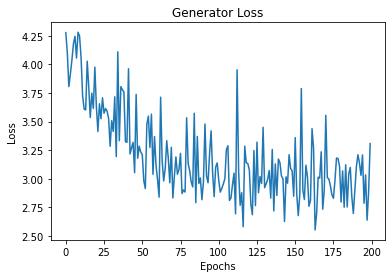

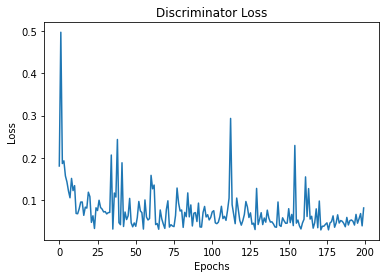

In [ ]:
ep = list(range(0, 200, 1))
plot(ep, loss_G_array, loss_D_array)

In [ ]:
model_path = get_model_name("yo", batch_size=1, learning_rate=0.0002, epoch=199)
state = torch.load(model_path)
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
def get_accuracy(model, data_loader, checking_data_loader): #gets accuracy using test set 
    total_error = 0
    errors = []
    print(data_loader.batch_size)


    for i in range(len(data_loader)): #this is how many batches there are in the loader
      dataiter = iter(data_loader) #gets a batch
      images, labels = dataiter.next()

      images, labels = images.cuda(), labels.cuda()

      dataiter_check = iter(checking_data_loader)
      images_check, labels_check = dataiter_check.next()

      images_check, labels_check = images_check.cuda(), labels_check.cuda()

      out = model.forward(images, images_check)

      out = out.transpose(1, 3) #flip one of the '256' columsn with the RGB colums so its easier to iterate over
      images_check = images_check.transpose(1, 3)

      #print(out.size())
      #print(images_check.size())

      out_numpy = out.cpu().detach().numpy() #turn into numpy so its easier to compare 
      images_check_numpy = images_check.cpu().detach().numpy()

      for index in range(data_loader.batch_size): #for each image in the batch
        iter_error = 0
        for x in range(256):
          for y in range(256):
            #print(out_numpy[index][x][y][0])
            #print(images_check_numpy[index][x][y][0])
            #print("R1: " + str(out_numpy[index][x][y][0]))
            #print("R2: " + str(images_check_numpy[index][x][y][0]))
            #print("G1: " + str(out_numpy[index][x][y][1]))
            #print("G2: " + str(images_check_numpy[index][x][y][1]))
            #print("B1: " + str(out_numpy[index][x][y][2]))
            #print("B2: " + str(images_check_numpy[index][x][y][2]))
            if (abs(out_numpy[index][x][y][0] - images_check_numpy[index][x][y][0]) > 0.1): #if the R, G, or B pixels are different, add an error point and move on to next pixel
              iter_error += 1
              continue
            if (abs(out_numpy[index][x][y][1] - images_check_numpy[index][x][y][1]) > 0.1):
              iter_error += 1
              continue
            if (abs(out_numpy[index][x][y][2] - images_check_numpy[index][x][y][2]) > 0.1): 
              iter_error += 1
              continue
        errors.append(iter_error / (256 * 256)) #calculate error in that single image



    total_error = sum(errors) / len(errors) #calculate total error

    return total_error

In [ ]:
get_accuracy(model, test_sat_loader, test_map_loader)

1


0.2715353879061612